Esto lo hice yo para tener a mano el dataset, subi el .zip de la tarea descompromido a mi drive a una carpeta llamada "Tarea3_NN" (Estas 3 celdas las voy a borrar antes de entregarlo).

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!cp -rf drive/MyDrive/Tarea3_NN/data ./
!cp -rf drive/MyDrive/Tarea3_NN/img ./

# Tarea 3: PINNs, Redes Recurrentes y Transformers

En esta Tarea Trabajaremos Con [Pytorch](https://pytorch.org/), una librería de Deep Learning de código abierto desarrollada por Facebook. Pytorch es una librería de Deep Learning que se basa en el concepto de [Tensores](https://pytorch.org/docs/stable/tensors.html), que son similares a los arreglos de Numpy, pero con la diferencia de que pueden ser utilizados en una GPU para acelerar los cálculos.

Se escogio Pytorch por sobre Tensorflow o Keras ya que tiene un paquete de [diferenciacion automatica](https://pytorch.org/docs/stable/autograd.html) que nos permite calcular derivadas de forma automatica, lo que nos permite implementar de forma sencilla los modelos de redes neuronales y sobre todo trabajar con PINNs y modificar pequeños detalles de forma sencilla en el lopp de entrenamiento como lo es aplicar custom losses, etc.

Dado que la ultima seccion del curso esta enfocado a trabajar con series temporales, todos los problemas en esta tarea de alguna u otra forma estan relacionados con series temporales o secuencias.

# 1. Imports

In [3]:
#data
import numpy as np
import pandas  as pd

# torch
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Preprocessing
from sklearn.preprocessing import MinMaxScaler

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error

device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(123)

En esta tarea tenemos 2 Secciones obligatorias, la parte de Redes Recurrentes y la Parte de Transformers, pero como no hay desafio Kaggle se añadio una seccion extra sobre PINNS (Physics Informed Neural Networks) la cual es opcional y sirve como bonus para la nota final.

Dado que no hay desafio Kaggle se incentiva a ser creativos y modificar los codigos, esto tambien añadira un bonus para la tarea.

# Parte 2: Redes Recurrentes

En esta tarea no hay desafio kaggle, por lo que en esta seccion deberan utilizar su creatividad para resolver un problema de series temporales, utilizando redes recurrentes.

## 2.1 Cargar Datos

In [4]:
train_df = pd.read_csv("data/DailyClimate_Train.csv")
test_df = pd.read_csv("data/DailyClimate_test.csv")

## 2.2 EDA & data Viz

En esta seccion deberan realizar un analisis exploratorio de los datos, generar visualizaciones que les permitan entender mejor los datos con los que estan trabajando y sacar conclusiones de estos.

In [5]:
### Start code here ###
train_df.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1011.104548
std,7.348103,16.769652,4.561602,180.231668
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.580357
50%,27.714286,62.625000,6.221667,1008.563492
75%,31.305804,72.218750,9.238235,1014.944901
max,38.714286,100.000000,42.220000,7679.333333


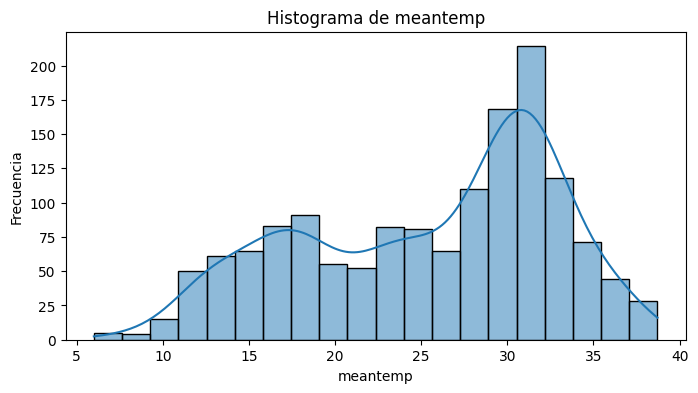

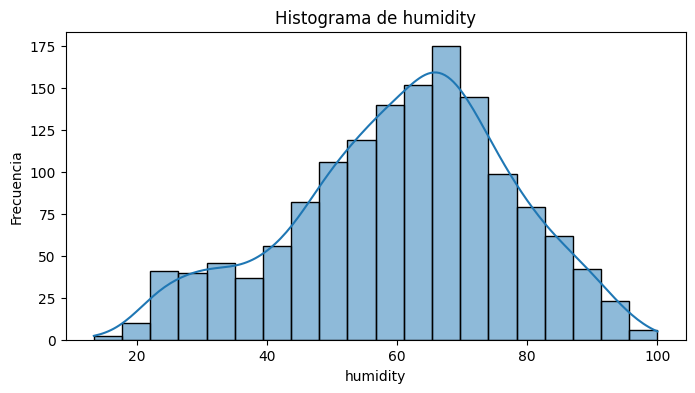

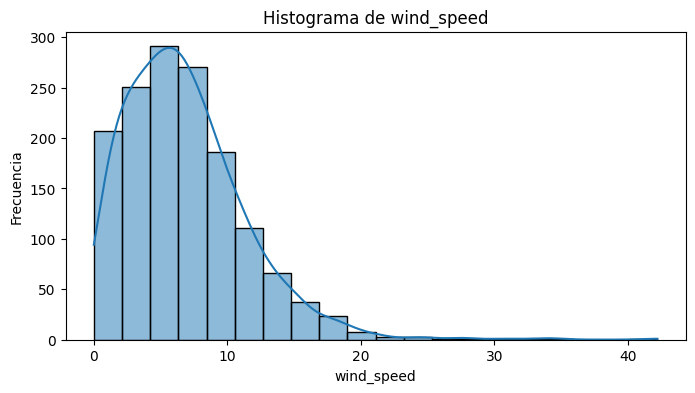

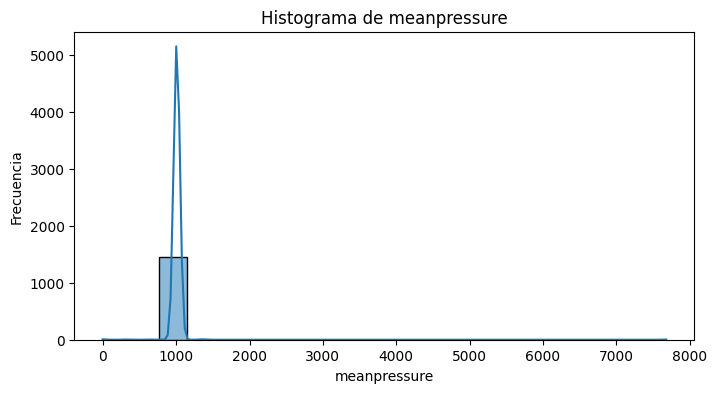

In [6]:
#Graficos de ejemplo
for column in train_df.columns[1:]:
    plt.figure(figsize=(8, 4))
    sns.histplot(train_df[column], bins=20, kde=True)
    plt.title(f'Histograma de {column}')
    plt.xlabel(column)
    plt.ylabel('Frecuencia')
    plt.show()

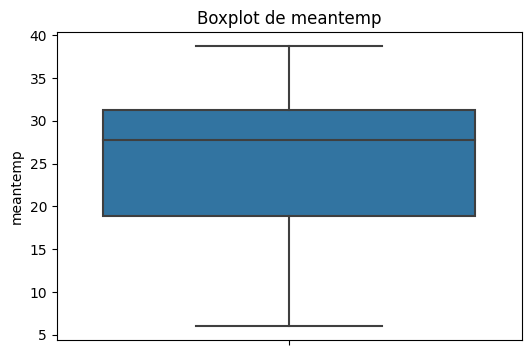

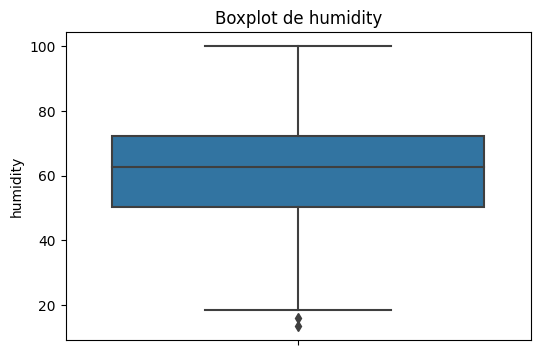

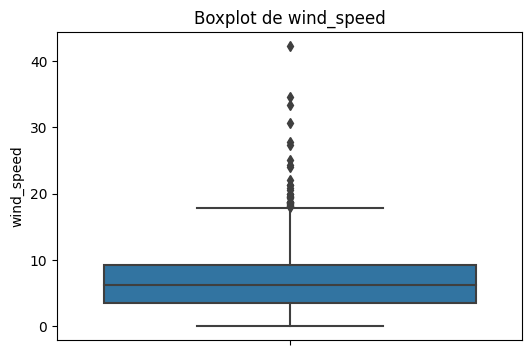

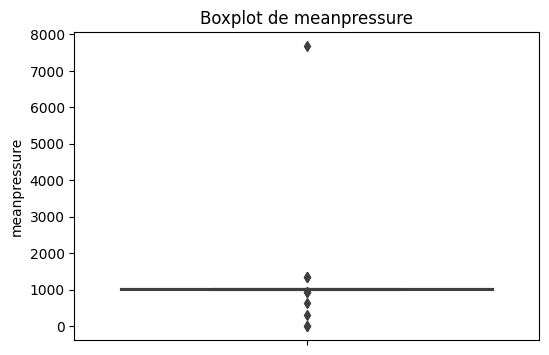

In [7]:
for column in train_df.columns[1:]:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=train_df, y=column)
    plt.title(f'Boxplot de {column}')
    plt.ylabel(column)
    plt.show()

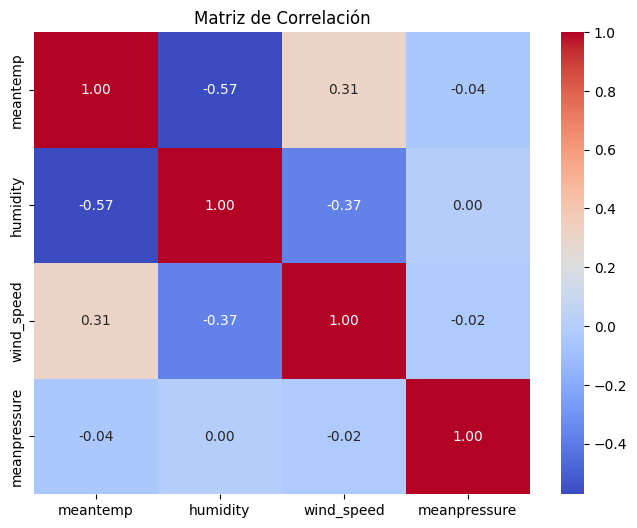

In [8]:
corr_matrix = train_df.drop(columns=['date']).corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()

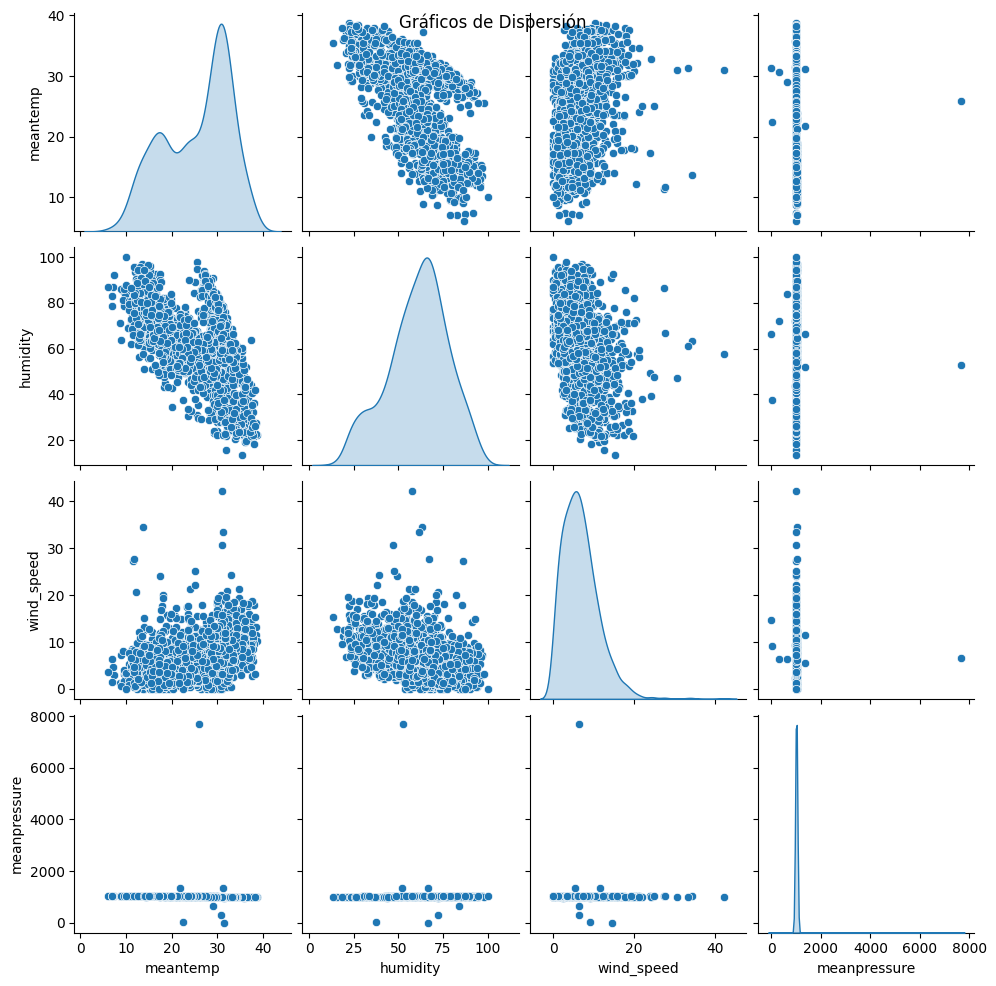

In [9]:
sns.pairplot(train_df, vars=train_df.columns[1:], diag_kind='kde')
plt.suptitle('Gráficos de Dispersión')
plt.show()

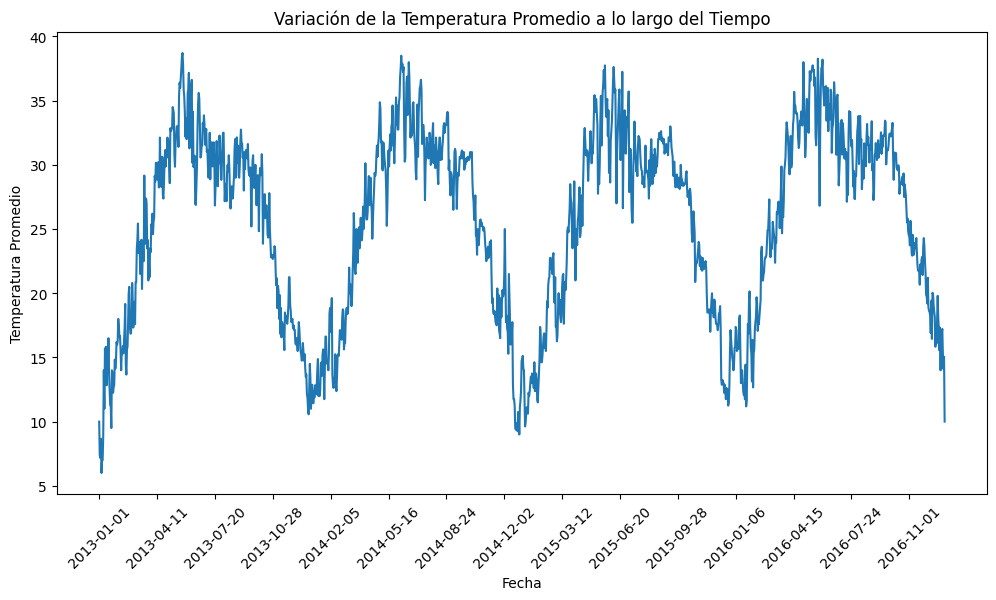

In [10]:
subset_dates = train_df['date'][::100]
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='meantemp', data=train_df)
plt.title('Variación de la Temperatura Promedio a lo largo del Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Temperatura Promedio')
plt.xticks(rotation=45)
plt.xticks(subset_dates)
plt.show()

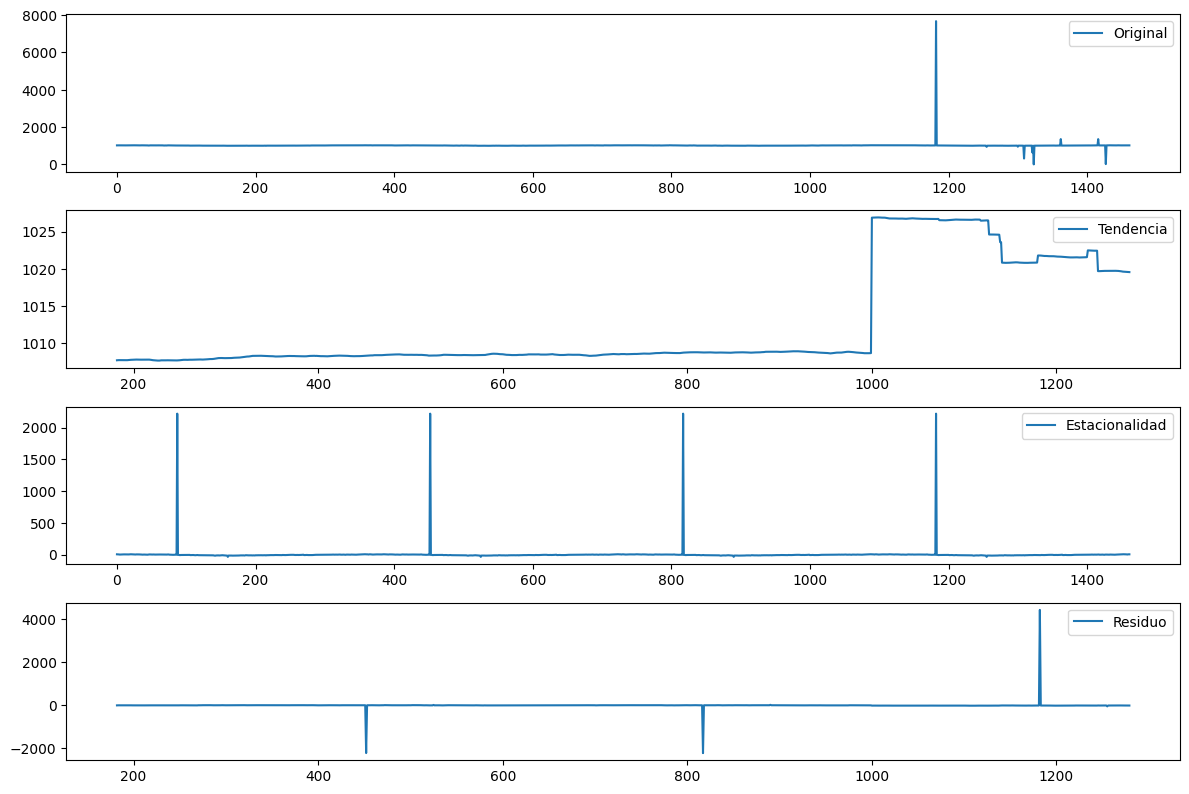

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

serie_temporal = train_df['meanpressure']

# Descomponer la serie temporal
descomposicion = seasonal_decompose(serie_temporal, model='additive', period=365)

# Extraer las componentes
tendencia = descomposicion.trend
estacionalidad = descomposicion.seasonal
residuo = descomposicion.resid

# Graficar las componentes
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(serie_temporal, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(tendencia, label='Tendencia')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(estacionalidad, label='Estacionalidad')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residuo, label='Residuo')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

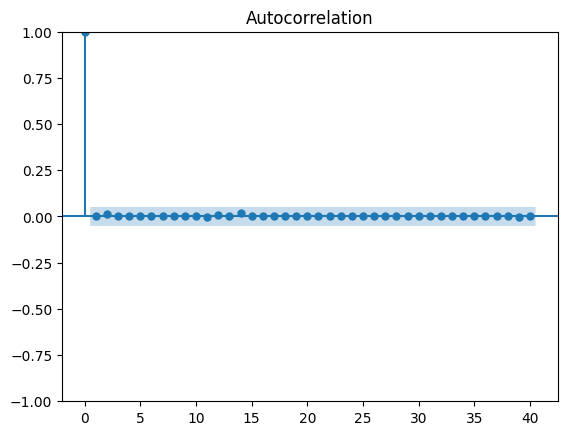

<Figure size 1200x600 with 0 Axes>

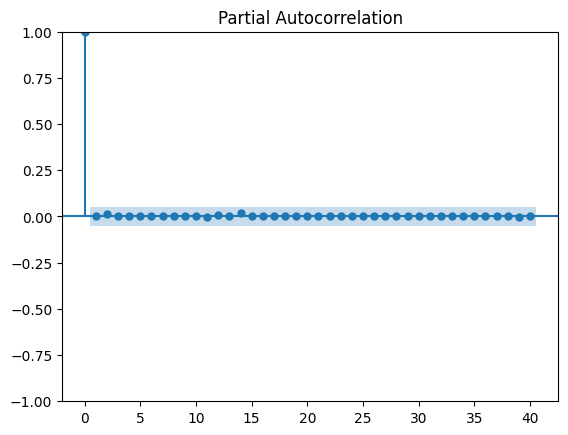

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

serie_temporal = train_df['meanpressure']

# Plot de Autocorrelación
plt.figure(figsize=(12, 6))
plot_acf(serie_temporal, lags=40)
plt.show()

# Plot de Autocorrelación Parcial
plt.figure(figsize=(12, 6))
plot_pacf(serie_temporal, lags=40)
plt.show()

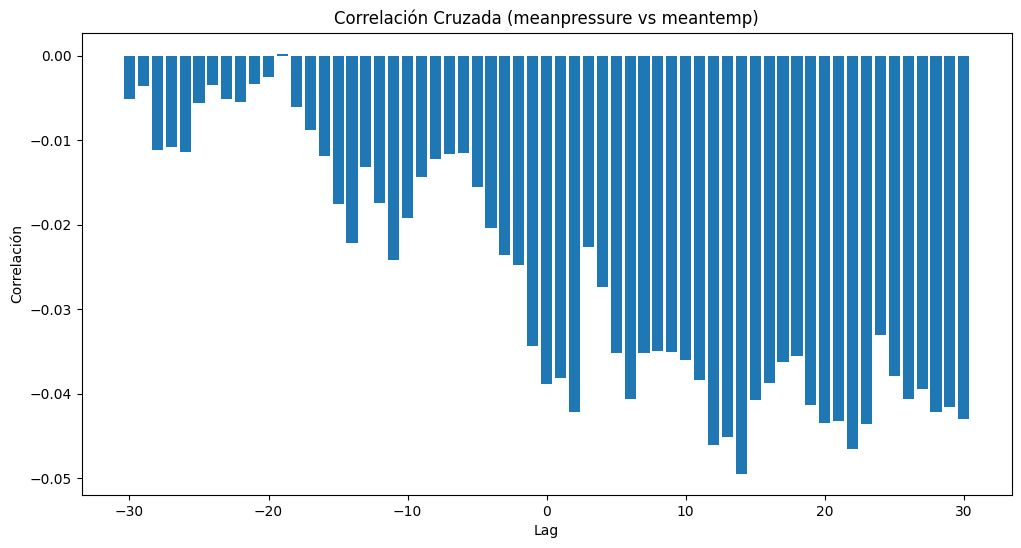

In [13]:
# Calcula la correlación cruzada
lags = range(-30, 31)
ccorrs = [serie_temporal.corr(train_df['meantemp'].shift(lag)) for lag in lags]

# Graficar la correlación cruzada
plt.figure(figsize=(12, 6))
plt.bar(lags, ccorrs)
plt.title('Correlación Cruzada (meanpressure vs meantemp)')
plt.xlabel('Lag')
plt.ylabel('Correlación')
plt.show()

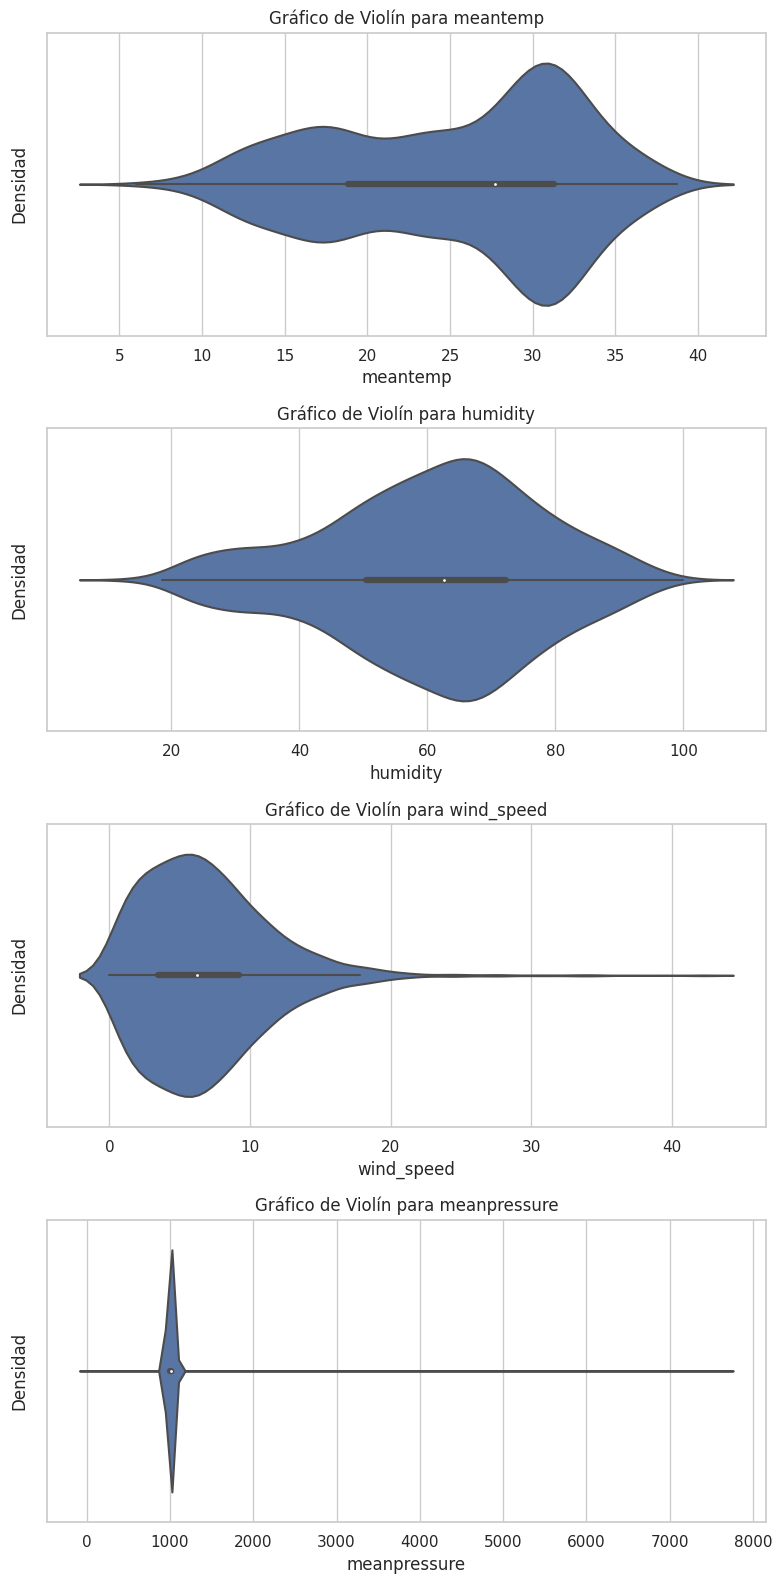

In [14]:
# Lista de columnas para las cuales quieres hacer gráficos de violín
columns = ['meantemp', 'humidity', 'wind_speed', 'meanpressure']

# Configuración para la visualización
sns.set(style="whitegrid")

# Crear una figura y un conjunto de subtramas
fig, axes = plt.subplots(len(columns), 1, figsize=(8, 4 * len(columns)))

# Iterar a través de las columnas y crear un gráfico de violín para cada una
for i, col in enumerate(columns):
    sns.violinplot(ax=axes[i], x=train_df[col])
    axes[i].set_title(f'Gráfico de Violín para {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Densidad')

plt.tight_layout()
plt.show()

## 2.3 Preprocesamiento

En esta seccion deberan aplicar las transformaciones necesarias a los datos para poder entrenar su modelo, crear columnas, eliminar columnas, escalar los datos, etc.

In [15]:
objective_col = 'meantemp' # columna objetivo
selected_cols = train_df.drop(columns=[objective_col]).select_dtypes(include='number').columns.tolist() #TODO # lista de columnas seleccionadas para entrenar

In [16]:
from sklearn.preprocessing import MinMaxScaler

# Convertir la columna de fecha a datetime y establecer como índice
train_df['date'] = pd.to_datetime(train_df['date'])
train_df.set_index('date', inplace=True)
test_df['date'] = pd.to_datetime(test_df['date'])
test_df.set_index('date', inplace=True)

# Eliminar valores atípicos en meanpressure
train_df = train_df[train_df['meanpressure'] <= 2000]
test_df = test_df[test_df['meanpressure'] <= 2000]

# Interpolar los valores faltantes
train_df.interpolate(method='time', inplace=True)
test_df.interpolate(method='time', inplace=True)

# Inicializar MinMaxScaler con el rango deseado (-1, 1)
scaler = MinMaxScaler(feature_range=(-1, 1))

# Asumiendo que selected_cols ya está definido
# Aplicar el escalado en las columnas seleccionadas
train_df[selected_cols] = scaler.fit_transform(train_df[selected_cols])
test_df[selected_cols] = scaler.transform(test_df[selected_cols])

# Concatenar los dataframes para visualizaciones posteriores
new = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)
new[selected_cols] = scaler.transform(new[selected_cols])

# Mostrar las primeras filas para verificar los cambios
print(train_df.head())
print(test_df.head())

             meantemp  humidity  wind_speed  meanpressure
date                                                     
2013-01-01  10.000000  0.641914   -1.000000      0.502900
2013-01-02   7.400000  0.815182   -0.858835      0.506047
2013-01-03   7.166667  0.699670   -0.780515      0.507326
2013-01-04   8.666667  0.337734   -0.941576      0.505113
2013-01-05   6.000000  0.695820   -0.824728      0.504129
             meantemp  humidity  wind_speed  meanpressure
date                                                     
2017-01-01  15.913043  0.673554   -0.870039     -0.908470
2017-01-02  18.500000  0.473781   -0.862888      0.506752
2017-01-03  17.111111  0.581591   -0.809727      0.506834
2017-01-04  18.700000  0.308086   -0.784699      0.502949
2017-01-05  18.388889  0.421159   -0.843676      0.500933


<ipython-input-16-a4e991b441cf>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.interpolate(method='time', inplace=True)
<ipython-input-16-a4e991b441cf>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[selected_cols] = scaler.fit_transform(train_df[selected_cols])


In [17]:
# En este ejemplo nos quedamos solo con las columnas numericas, pero la idea es que en la lista anterior se incluyan las columnas que se quieran usar para entrenar el modelo, columnas nuevas que hayan creado o modificado en el preprocesamiento.
# selected_cols = train_df.drop(columns=objective_col).select_dtypes(include='number').columns.tolist() #solo ejecutar a modo de ejemplo

In [18]:
# IMPORTANTE: agregamos la columna objetivo al final de la lista, deben asegurarse de que este al final para el correcto funcionamiento del codigo
selected_cols.append(objective_col)
selected_cols

['humidity', 'wind_speed', 'meanpressure', 'meantemp']

In [19]:
tr_timeseries = train_df[selected_cols].values.astype('float32')
te_timeseries = test_df[selected_cols].values.astype('float32')

In [20]:
# concatenamos los dataframes para despues hacer las visualizaciones, No borrar ni modificar
#new = pd.concat([train_df, test_df], axis=0).reset_index().drop('index', axis=1)
new_timeseries = new[selected_cols].values.astype('float32')
shape = new_timeseries.shape[1]

## 2.4 Dataset y DataLoader

In [21]:
def create_dataset(dataset, lookback, shape):
    """Funcion para crear los tensores de entrenamiento y test
    dataset: np.ndarray
    lookback: int (numero de dias a considerar o largo de la secuencia)
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[:,:shape-1][i:i+lookback]
        target = dataset[:, shape-1][i:i+lookback]
        X.append(feature)
        y.append(target)
    # Convierte las listas a np.ndarray antes de convertirlas en tensores
    X = np.array(X)
    y = np.array(y)
    return torch.tensor(X), torch.tensor(y)

In [22]:
lookback = 7 #consideraremos los ultimos 7 dias para predecir el dia siguiente

train, test = tr_timeseries, te_timeseries
X_train, y_train = create_dataset(train, lookback=lookback, shape=shape)
X_test, y_test = create_dataset(test, lookback=lookback, shape=shape)

In [23]:
loader = data.DataLoader(data.TensorDataset(X_train, y_train), batch_size = 8, shuffle = True) #dataloader para entrenar los modelos de Pytorch

## 2.5 Modelo Recurrente

En esta seccion se implementa uan clase base para modelos recurrentes, pueden utilizar esta clase o pueden modificarla o crear una nueva clase si lo desean, recuerden que hay bonus por creatividad en esta tarea.

In [24]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout, bidirectional, rnn_class):
        super().__init__()
        # Verificar que rnn_class es una de las clases de RNN permitidas
        if rnn_class not in [nn.LSTM, nn.GRU, nn.RNN]:
            raise ValueError("rnn_class must be nn.LSTM, nn.GRU, or nn.RNN")

        # Inicializar la capa recurrente con la clase pasada como parámetro
        self.rnn = rnn_class(input_size=input_size,
                             hidden_size=hidden_size,
                             num_layers=num_layers,
                             batch_first=True,
                             bidirectional=bidirectional)

        # Calcular la dimensión de salida de la capa recurrente
        # Es doble si es bidireccional
        factor = 2 if bidirectional else 1

        self.dropout = nn.Dropout(dropout)
        self.linear1 = nn.Linear(hidden_size * factor, 64)
        self.linear2 = nn.Linear(64, 32)
        self.output_linear = nn.Linear(32, 1)

    def forward(self, x):
        # LSTM devuelve (output, (h_n, c_n)) mientras que GRU y RNN solo devuelve (output, h_n)
        x, _ = self.rnn(x)
        x = self.dropout(x)
        x = torch.relu(self.linear1(x))
        x = torch.relu(self.linear2(x))
        x = self.output_linear(x)
        return x

## 2.6 Hiperparámetros

Aca pueden variar los hiperparametros de la red recurrente, pueden agregar mas si lo desean, para mas informacion sobre los optimizadores pueden revisar la documentacion de [pytorch Optim](https://pytorch.org/docs/stable/optim.html), y para mas informacion sobre los criterios de perdida pueden revisar la documentacion de [pytorch Loss](https://pytorch.org/docs/stable/nn.html#loss-functions)

In [25]:
# Hiperparametros del modelo
input_size = shape-1
hidden_size = 50
num_layers = 2
dropout = 0.2
bidirectional = True #puede ser True o False
layer_type = nn.RNN #puede ser nn.RNN, nn.LSTM o nn.GRU

# Modelo
model = RNNModel(input_size, hidden_size, num_layers, dropout, bidirectional, layer_type)

#optimizador
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)

# loss func: MSE
loss_fn = nn.MSELoss()

## 2.7 Funciones de entrenamiento y evaluacion

En esta seccion se implementan funciones que nos ayudaran a entrenar y evaluar nuestro modelo, Pytorch no implementa metodos como .fit() por ende los tenemos que crear desde cero, al igual que antes sientanse libres de modificar o crear nuevas funciones, para mas informacion sobre el training loop pueden revisar la documentacion de [pytorch Custom Training](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html#custom-training-loop)

In [26]:
class CustomEarlyStopping:
    """
    Funcion para detener el entrenamiento cuando la loss de validacion no mejora
    """
    def __init__(self, patience=20, delta=0, verbose=False):
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_state = None
        self.best_y_pred = None

    def __call__(self, val_loss, model, X):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.best_state = model.state_dict()
            with torch.no_grad():
                self.best_y_pred = model(X)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}, score: {self.best_score}')

            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_state = model.state_dict()
            with torch.no_grad():
                self.best_y_pred = model(X)
            self.counter = 0

In [27]:
def train_model(model, optimizer, early_stopping):
    """
    Funcion para entrenar el modelo
    """
    best_score = None
    best_weights = None

    n_epochs = 200

    for epoch in range(n_epochs):
        model.train() # Entrenamiento
        for X_batch, y_batch in loader:
            y_pred = model(X_batch) # Forward pass
            loss = loss_fn(y_pred, y_batch.unsqueeze(2)) # Compute loss
            optimizer.zero_grad() # Zero gradients
            loss.backward() # Backward pass
            optimizer.step() # Update weights

        model.eval() # Validacion
        with torch.no_grad():
            y_pred = model(X_train)
            train_rmse = np.sqrt(loss_fn(y_pred, y_train.unsqueeze(2)))

            y_pred = model(X_test)
            test_rmse = np.sqrt(loss_fn(y_pred, y_test.unsqueeze(2)))

            if best_score is None or test_rmse < best_score:
                best_score = test_rmse
                best_weights = model.state_dict()

            early_stopping(test_rmse, model, X_test)

            # Check if early stopping criterion is met
            if early_stopping.early_stop:
                print("Early stopping")
                break

        if epoch % 10 == 0:
            print('*'*10, 'Epoch: ', epoch, '\ train RMSE: ', train_rmse, '\ test RMSE', test_rmse)

    return model, best_weights

In [28]:
def get_preds(model, best_weights):
    """
    Funcion para obtener las predicciones y desnormalizarlas
    """
    # Usamos los mejores pesos para hacer las predicciones
    if best_weights is not None:
        model.load_state_dict(best_weights)

        # Calculamos las predicciones
        with torch.no_grad():
            y_pred_train = model(X_train).clone().detach().cpu().numpy()
            y_pred_test = model(X_test).clone().detach().cpu().numpy()

        # Modificamos las dimensiones de las predicciones para luego graficarlas
        with torch.no_grad():
            train_predictions = np.ones_like(new_timeseries) * np.nan
            train_predictions[lookback: len(train)] = y_pred_train[:,-1,:]

            test_predictions = np.ones_like(new_timeseries) * np.nan
            test_predictions[len(train)+lookback:len(new_timeseries)] = y_pred_test[:,-1,:]

        return train_predictions, test_predictions

In [29]:
def plot_predictions(train_predictions, test_predictions, shape):
    """
    Funcion para graficar las predicciones
    """
    # plot
    plt.figure(figsize=(20,10))
    plt.plot(new_timeseries[:,shape-1], c = 'b', label = 'True')
    plt.plot(train_predictions[:,shape-1], c='r', label = 'Train')
    plt.plot(test_predictions[:,shape-1], c='g', label = 'Test')
    plt.legend()
    plt.show()

In [30]:
def plot_eval(test_predictions, shape):
    """
    Funcion para graficar las predicciones
    """

    # eval_df = pd.concat([test_df['meantemp'].reset_index(),pd.Series(test_predictions[:,shape-1][len(train):].reshape(-1).tolist())],axis=1).drop('index',axis=1) #creamos un dataframe con las predicciones y los valores reales
    eval_df = pd.concat([test_df['meantemp'].reset_index(drop=True), pd.Series(test_predictions[:, shape-1][len(train):].reshape(-1).tolist())], axis=1)

    eval_df.columns = ['real_meantemp', 'pred_meantemp'] #renombramos las columnas

    rmse = np.sqrt(mean_squared_error(eval_df.iloc[7:]['real_meantemp'], eval_df.iloc[7:]['pred_meantemp'])) #calculamos el rmse

    print(f'RMSE: {rmse}')

    fig = go.Figure(data = [
        go.Scatter(x = eval_df.index, y = eval_df['real_meantemp'], mode='lines', name = "Actual"),
        go.Scatter(x = eval_df.index, y = eval_df['pred_meantemp'], mode='lines', name="Predicted"),
    ])

    fig.update_layout(
        font = dict(size=17, family="Franklin Gothic"),
        template = 'simple_white',
        title = 'Real & Predicted Temperature'
    )

    fig.show()

## 2.8 Entrenamiento

In [31]:
early_stopping = CustomEarlyStopping(patience=15, verbose=True)
model, model_best_weights = train_model(model, optimizer, early_stopping)

********** Epoch:  0 \ train RMSE:  tensor(7.3561) \ test RMSE tensor(6.9039)
EarlyStopping counter: 1 out of 15, score: -6.9039177894592285
EarlyStopping counter: 1 out of 15, score: -5.280801773071289
EarlyStopping counter: 2 out of 15, score: -5.280801773071289
EarlyStopping counter: 3 out of 15, score: -5.280801773071289
EarlyStopping counter: 4 out of 15, score: -5.280801773071289
EarlyStopping counter: 5 out of 15, score: -5.280801773071289
********** Epoch:  10 \ train RMSE:  tensor(5.6076) \ test RMSE tensor(6.2912)
EarlyStopping counter: 6 out of 15, score: -5.280801773071289
EarlyStopping counter: 1 out of 15, score: -5.268187522888184
EarlyStopping counter: 2 out of 15, score: -5.268187522888184
EarlyStopping counter: 3 out of 15, score: -5.268187522888184
EarlyStopping counter: 4 out of 15, score: -5.268187522888184
EarlyStopping counter: 5 out of 15, score: -5.268187522888184
EarlyStopping counter: 6 out of 15, score: -5.268187522888184
EarlyStopping counter: 7 out of 15, 

In [32]:
train_predictions, test_predictions = get_preds(model, model_best_weights)

## 2.9 Evaluacion

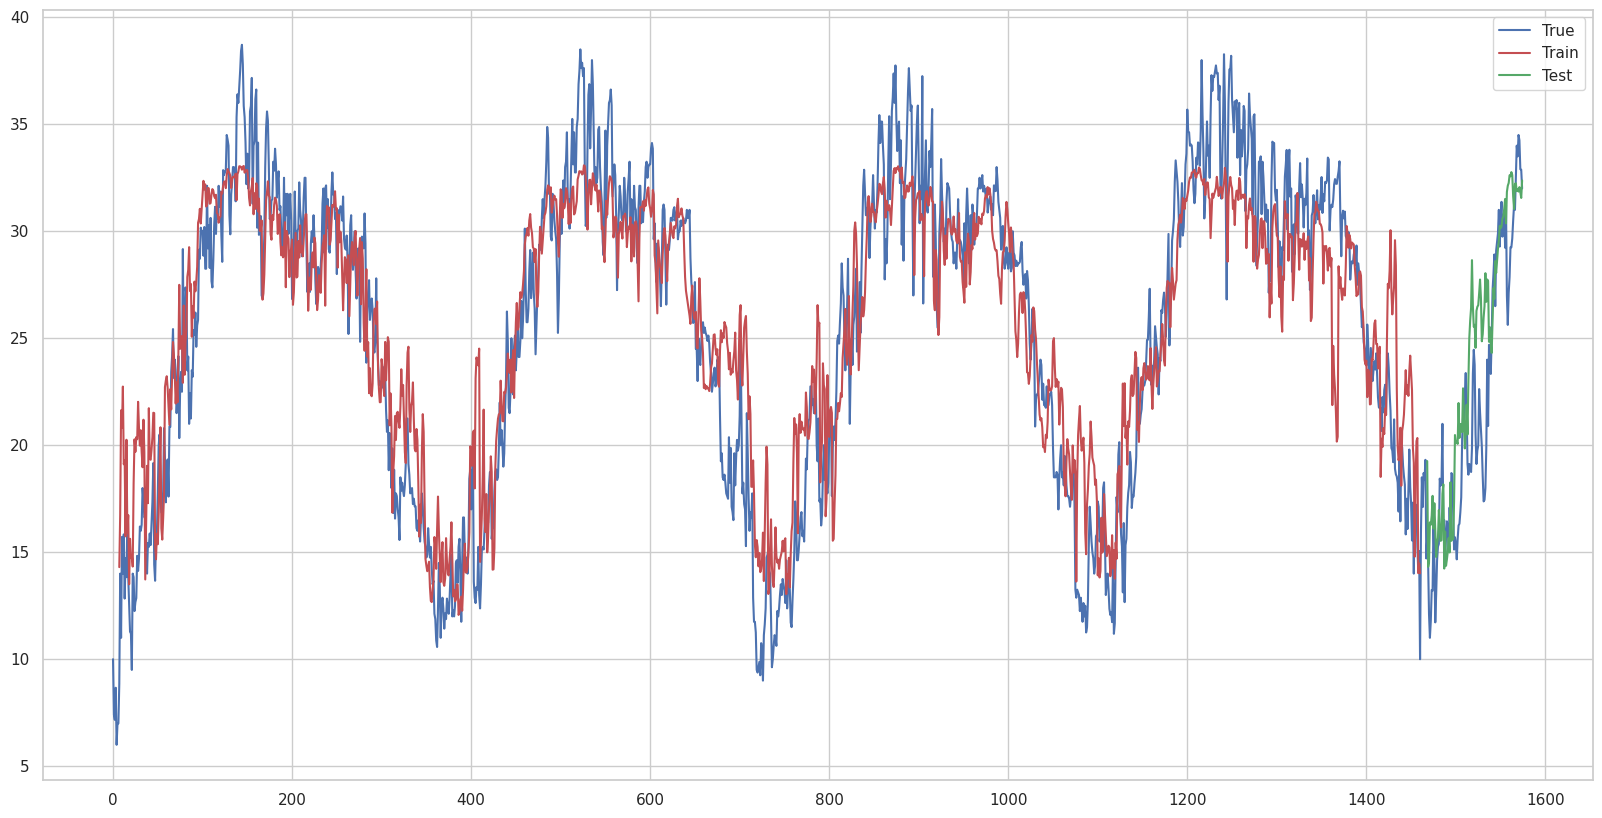

In [33]:
plot_predictions(train_predictions, test_predictions, shape)

In [34]:
plot_eval(test_predictions, shape)

RMSE: 3.7908157885437337


# Parte 3: Transformers

Para esta parte vamos a entrenar un transformer muy simple para que aprenda a generar texto como el del Quijote.

### 3.1 Cargar el dataset

In [35]:
with open('data/el_quijote.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [36]:
print("length of dataset in characters: ", len(text))

length of dataset in characters:  1038397


In [37]:
# Visualizamos los primeros 1000 caracteres
print(text[:1000])

DON QUIJOTE DE LA MANCHA
Miguel de Cervantes Saavedra

PRIMERA PARTE
CAPÍTULO 1: Que trata de la condición y ejercicio del famoso hidalgo D. Quijote de la Mancha
En un lugar de la Mancha, de cuyo nombre no quiero acordarme, no ha mucho tiempo que vivía un hidalgo de los de lanza en astillero, adarga antigua, rocín flaco y galgo corredor. Una olla de algo más vaca que carnero, salpicón las más noches, duelos y quebrantos los sábados, lentejas los viernes, algún palomino de añadidura los domingos, consumían las tres partes de su hacienda. El resto della concluían sayo de velarte, calzas de velludo para las fiestas con sus pantuflos de lo mismo, los días de entre semana se honraba con su vellori de lo más fino. Tenía en su casa una ama que pasaba de los cuarenta, y una sobrina que no llegaba a los veinte, y un mozo de campo y plaza, que así ensillaba el rocín como tomaba la podadera. Frisaba la edad de nuestro hidalgo con los cincuenta años, era de complexión recia, sec

### 3.2 Preprocesar el dataset

Vamos a crear un tokenizador muy simple que convierta el texto en una secuencia de números.

In [38]:
chars = sorted(list(set(text))) #obtener los caracteres unicos del texto
vocab_size = len(chars)
print('Caracteres unicos:',''.join(chars))
print('Largo del vocabulario:',vocab_size)

Caracteres unicos: 
 !"'(),-.0123456789:;<?ABCDEFGHIJKLMNOPQRSTUVWXYZ[]abcdefghijlmnopqrstuvxyz¡«»¿̀́̃̈–‘’“”
Largo del vocabulario: 89


### 3.3 Encoding y Decoding

Ahora que tenemos el tokenizador, vamos a crear una función que nos permita convertir el texto en una secuencia de números y viceversa.

In [39]:
# Mapeamos cada caracter a un entero
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: toma un string, devuelve una lista de enteros
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: toma una lista de enteros, devuelve un string

print(encode("Quijote de la Mancha"))
print(decode(encode("Quijote de la Mancha")))

[40, 71, 60, 61, 65, 70, 56, 1, 55, 56, 1, 62, 52, 1, 36, 52, 64, 54, 59, 52]
Quijote de la Mancha


**pregunta: Que otros tipos de tokenizaciones ademas de por caracteres existen y cuales serian las ventajas?**

Otros tipos de tokenizaciones son:
- Por sub-palabra: Equilibrado entre tokenizacion por palabras y caracteres, descompone las palabras en subunidades, lo que permite que el modelo tenga un tamaño de vocabulario razonable mientras es capz de aprender representaciones significativas independiente del contexto.
- Por palabra: Facilita el análisis de la frecuencia de palabras y la identificación de frases comunes pero lleva a una gran vocabulario.
- Por frase: Permite analizar la estructura y el flujo de texto a un nivel más alto.

**Pregunta: ¿que otras tecnicas se utilizan antes de tokenizar en problemas de NLP?**

- Limpiar el texto en caso de que tenga etiquetas HTML.
- Dependiendo del contexto eliminar caracteres especiales o números.
- Normalización de texto como convertir el texto a minúsculas.
- Eliminar *Stop Words* que no aportan mucho al significado, como "el", "la", "en".

Entre otras.

### 3.4 Train y Val Split

In [40]:
# Vamos a Codificar el texto y llevarlo a un tensor de Pytorch
data = torch.tensor(encode(text), dtype=torch.long)

# Separamos en train y validation
n = int(len(data) * 0.8) # % de los datos para entrenar
train_data = data[:n]
val_data = data[n:]

print(train_data.shape, train_data.dtype)
print(train_data[:1000]) # los primeros 1000 caracteres del texto codificado

torch.Size([830717]) torch.int64
tensor([27, 38, 37,  1, 40, 44, 32, 33, 38, 43, 28,  1, 27, 28,  1, 35, 24,  1,
        36, 24, 37, 26, 31, 24,  0, 36, 60, 58, 71, 56, 62,  1, 55, 56,  1, 26,
        56, 68, 72, 52, 64, 70, 56, 69,  1, 42, 52, 52, 72, 56, 55, 68, 52,  0,
         0, 39, 41, 32, 36, 28, 41, 24,  1, 39, 24, 41, 43, 28,  0, 26, 24, 39,
        32, 81, 43, 44, 35, 38,  1, 11, 20,  1, 40, 71, 56,  1, 70, 68, 52, 70,
        52,  1, 55, 56,  1, 62, 52,  1, 54, 65, 64, 55, 60, 54, 60, 65, 81, 64,
         1, 74,  1, 56, 61, 56, 68, 54, 60, 54, 60, 65,  1, 55, 56, 62,  1, 57,
        52, 63, 65, 69, 65,  1, 59, 60, 55, 52, 62, 58, 65,  1, 27,  9,  1, 40,
        71, 60, 61, 65, 70, 56,  1, 55, 56,  1, 62, 52,  1, 36, 52, 64, 54, 59,
        52,  0, 28, 64,  1, 71, 64,  1, 62, 71, 58, 52, 68,  1, 55, 56,  1, 62,
        52,  1, 36, 52, 64, 54, 59, 52,  7,  1, 55, 56,  1, 54, 71, 74, 65,  1,
        64, 65, 63, 53, 68, 56,  1, 64, 65,  1, 67, 71, 60, 56, 68, 65,  1, 52,
       

### 3.5 Generando sequencias de texto

El transformer es una arquitectura de secuencias, por lo que necesitamos generar las secuencias de texto que vamos a utilizar para entrenar el modelo.

In [41]:
batch_size = 4 # cuantas secuencias de texto vamos a procesar en paralelo
block_size = 8 # definimos el largo de nuestra sequencia

def get_batch(split):
    # generamos un batch de datos
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

In [42]:
xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('----')

for b in range(batch_size): # batch dimension
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"cuando el input es {context} el target es: {target}")

inputs:
torch.Size([4, 8])
tensor([[ 1, 62, 65, 69,  1, 63, 65, 75],
        [55, 65, 69,  1, 52, 70, 56, 64],
        [69, 65, 69, 66, 60, 68, 65,  7],
        [64,  1, 71, 64, 52,  1, 54, 52]], device='cuda:0')
targets:
torch.Size([4, 8])
tensor([[62, 65, 69,  1, 63, 65, 75, 65],
        [65, 69,  1, 52, 70, 56, 64, 70],
        [65, 69, 66, 60, 68, 65,  7,  1],
        [ 1, 71, 64, 52,  1, 54, 52, 62]], device='cuda:0')
----
cuando el input es tensor([1], device='cuda:0') el target es: 62
cuando el input es tensor([ 1, 62], device='cuda:0') el target es: 65
cuando el input es tensor([ 1, 62, 65], device='cuda:0') el target es: 69
cuando el input es tensor([ 1, 62, 65, 69], device='cuda:0') el target es: 1
cuando el input es tensor([ 1, 62, 65, 69,  1], device='cuda:0') el target es: 63
cuando el input es tensor([ 1, 62, 65, 69,  1, 63], device='cuda:0') el target es: 65
cuando el input es tensor([ 1, 62, 65, 69,  1, 63, 65], device='cuda:0') el target es: 75
cuando el input es tenso

### 3.6 Creando el modelo

Vamos a crear un modelo naive que consiste en una capa de embedding, y una capa de salida que predice la siguiente palabra

In [43]:
class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # cada token se representa como un vector de vocab_size dimensiones
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):

        # idx y targets son (B, T) arrays de indices en el vocabulario
        logits = self.token_embedding_table(idx) # (B,T,C)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            logits, loss = self(idx)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

**Pregunta: Explique que hace la funcion Generate (indicar que hace cada linea de la funcion)**

```python
"""
Toma un arreglo (secuencia) de indices inicial y genera una secuencia, agregando un token a la vez, hasta alcanzar el número especificado de tokens nuevos. Utiliza el modelo para predecir el siguiente token basándose en la secuencia existente y luego actualiza la secuencia con este nuevo token.
Parametros:
  idx: array de indices en el vocabulario.
  max_new_tokens: número máximo de tokens nuevos a generar.
"""
def generate(self, idx, max_new_tokens):
  # Se generara un token en cada iteración
  for _ in range(max_new_tokens):

    # LLama al método self (que hace referencia al método foward) con el array de indices como parametro, esto retorna "logits" que son puntuaciones sin normalizar para cada token del vocabulario y la "perdida" que no se utiliza en este metodo.
    logits, loss = self(idx)
  
    # Extraer los logits del último token
    logits = logits[:, -1, :]
  
    # Convertir los valores de los logits del último token y convertirlos a probabilidades con la función softmax.
    probs = F.softmax(logits, dim=-1)
  
    # Selecciona el siguiente token con mayor probabilidad.
    idx_next = torch.multinomial(probs, num_samples=1)
  
    # Concatena el indice del token al arreglo.
    idx = torch.cat((idx, idx_next), dim=1)
  
  # Retorna el array de indices extendido por los indices concatenados.
  return idx
```

In [44]:
# Hiperparametros
naive_model = BigramLanguageModel(vocab_size).to(device)
optimizer = optim.Adam(naive_model.parameters())
batch_size = 128
epochs = 100

En esta seccion deberan crear un loop de entrenamiento para esto pueden revisar la documentacion de [Pytorch](https://pytorch.org/docs/stable/index.html)

In [45]:
# Entrenamiento
for i in range(epochs):
    # obtenemos un batch de datos
    x, y = get_batch('train')

    # Obtenemos las predicciones del modelo y la loss
    logits, loss = naive_model(x, y)

    # reseteamos el gradiente
    optimizer.zero_grad()

    # Backward Pass
    loss.backward()

    # Actualizamos los pesos
    optimizer.step()

    # Visualizamos el resultado cada 10 iteraciones
    if i % 10 == 0:
        print(f"Epoch {i} | Loss {loss.item():.4f}")

Epoch 0 | Loss 4.9881
Epoch 10 | Loss 4.9469
Epoch 20 | Loss 4.9610
Epoch 30 | Loss 4.9559
Epoch 40 | Loss 4.9054
Epoch 50 | Loss 4.9426
Epoch 60 | Loss 4.9261
Epoch 70 | Loss 4.9450
Epoch 80 | Loss 4.8738
Epoch 90 | Loss 4.8311


In [46]:
print('loss:', loss.item())
print(decode(naive_model.generate(idx = torch.zeros((1, 1), dtype=torch.long).to(device), max_new_tokens=100)[0].tolist()))

loss: 4.880892276763916

p¿Hye4qhJq5L)Ncy< “"MCbẽI-̀H5oxhvdC[2b96P61G5J̀e(»i"9EYC‘<¿1S7«7«97 ̈Xi)yPcFfrq

i¿tdy0K̃Sp3[Va'yJS


Como vemos el modelo no es capaaz de generar texto coherente, para esto vamos a utilizar un transformer.

### 3.7 Transformer

El transformer es una arquitectura de secuencias que utiliza atención para poder capturar dependencias de largo plazo, en esta seccion deberan completar las lineas de codigo faltantes, para esto pueden revisar el paper originar [Attention is all you need](https://arxiv.org/pdf/1706.03762.pdf) y la documentacion de [Pytorch](https://pytorch.org/docs/stable/index.html)

In [47]:
n_embd = 512 # dimension de los embeddings
n_head = 8 # numero de cabezas de atencion
n_layer = 6 # numero de capas
dropout = 0.1 # dropout

In [48]:
class Head(nn.Module):
    """ cabezal de auto-atencion """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size)
        self.query = nn.Linear(n_embd, head_size)
        self.value = nn.Linear(n_embd, head_size)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)
        q = self.query(x)

        # Calcula la matriz de pesos (Afinidades)
        wei = q @ k.transpose(-2,-1) * (C**-0.5) # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        softmax = F.softmax(wei, dim=-1)
        dropout = self.dropout(softmax)

        # Calcula la ponderacion de los valores por los pesos atencionales
        v = self.value(x)

        out = dropout @ v

        return out

**Pregunta: En sus propias palabras explique como funciona el mecanismo de auto-atencion**

La auto-atención es un mecanismo de atención que permite que los modelos se enfoquen en diferentes partes de la entrada al procesar cada token en un contexto, al implementarlo se logra que cada token en una oración tenga en cuenta al resto de tokens de la misma oración para representar mejor su significado, en vez de solo centrarse en el token actual. Esto hace que los modelos consideren la interacción entre todas las palabras de la entrada, independiente de su ubicación dentro del contexto.



In [49]:
class MultiHeadAttention(nn.Module):
    """ Multiples cabezales de auto-atencion """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

In [50]:
class FeedFoward(nn.Module):
    """ Capa FeedForward """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 2048),
            nn.ReLU(),
            nn.Linear(2048, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

In [51]:
class Block(nn.Module):
    """ Bloque de Transformer """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

**Pregunta: Que parte del transformer estamos implementando?**

En la celda anterior se esta implementando un bloque.

Cada bloque tiene 2 partes capas principales:
- _MultiHeadAttention_: Permite al modelo enfocarse en diferentes partes de la entrada. Esta capa esta compuesto por una concatenación de instancias _Head's_, donde cada "cabeza" calcula la atención individualmente.
- _FeedForward_: Red simple (con 2 capas lineales y una capa ReLU intermedia) que transforma la salida de la capa _MultiHeadAttention_.

Además, a cada capa se le realiza una normalización.

In [52]:
# Ahora definimos el modelo completo con los bloques de Transformer
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, loss = self(idx_cond)
            logits = logits[:, -1, :] # (B, C)
            probs = F.softmax(logits, dim=-1) # (B, C)
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

**Bonus: Desde que salio el transformer se han publicado mejoras para esta arquitectura, si implementan alguna mejora con la referencia del paper en cuestion obtendran un bonus, se atreven?**

In [53]:
model = BigramLanguageModel()
m = model.to(device)

# Parametros del modelo
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# Hiperparametros
lr = 1e-3
optimizer = optim.Adam(m.parameters(), lr=lr, betas=(0.9,0.98), eps=1e-9)
epochs = 5000
eval_interval = 100
eval_iters = 200

19.010649 M parameters


In [54]:
# Funcion de evaluar el modelo
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [55]:
for i in range(epochs):
    # cada 100 iteraciones evaluamos el modelo
    if i % eval_interval == 0 or i == epochs - 1:
        losses = estimate_loss()
        print(f"step {i}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # Obtenemos un batch de datos
    x, y = get_batch('train')

    # Obtener las predicciones del modelo y la loss
    logits, loss = model(x, y)

    # reseteamos el gradiente
    optimizer.zero_grad()

    # Backward Pass
    loss.backward()

    # Actualizamos los pesos
    optimizer.step()

step 0: train loss 4.6421, val loss 4.6456
step 100: train loss 2.1759, val loss 2.1949
step 200: train loss 2.0643, val loss 2.0801
step 300: train loss 1.9719, val loss 1.9972
step 400: train loss 1.9241, val loss 1.9484
step 500: train loss 1.8935, val loss 1.9119
step 600: train loss 1.8600, val loss 1.8862
step 700: train loss 1.8367, val loss 1.8686
step 800: train loss 1.8147, val loss 1.8387
step 900: train loss 1.7982, val loss 1.8236
step 1000: train loss 1.7882, val loss 1.8105
step 1100: train loss 1.7712, val loss 1.8047
step 1200: train loss 1.7554, val loss 1.7862
step 1300: train loss 1.7501, val loss 1.7780
step 1400: train loss 1.7427, val loss 1.7769
step 1500: train loss 1.7285, val loss 1.7585
step 1600: train loss 1.7293, val loss 1.7620
step 1700: train loss 1.7158, val loss 1.7407
step 1800: train loss 1.7051, val loss 1.7485
step 1900: train loss 1.7017, val loss 1.7354
step 2000: train loss 1.6879, val loss 1.7214
step 2100: train loss 1.6857, val loss 1.7208


In [56]:
# Generamos las predicciones
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))


Marienanda
Cercaña; y fuesesto es fierta mura cercosa quellos, y es, agravimiento más de este mucho muchos había de los mundo Sancho, escudero volviendo Lotario. ¿Puesto-; y que a los que era esa.
Calé en la manera: traído se en que le advienda dejó de avermad y su triste dicho y cama te, bustar y buscaciano, admire yo limperieron estar la mucho de IgO de Ladura, aman caballero.
Pues se bueno de habían hecho, sin de que les tanca, que no habiendo ni otros mío, pues con sus cerrabas, y quejo; aunque hizo haber pecho en tanta lágrimas y aun este aherróstea, y, según le que pro, no quizá a estaba que la modantes, el cuantes que mi amigo, que, escondidoso; y que lo primero en tu midio, Sancho hijura que que él mal merecióselo, dijo
están tratos figirlo tuvo tomanda, sabimiento; que yo me las cautipio, y el ciella y echó a esto mío, llevando de hico el monto, tambigos lo, y todoses.
-En más paso?
-¿Entra vencido de Crruelió, dejar escudo en la caballero, de caballero en 

Ahora las predicciones ya tienen un poco de sentido, podemos seguir entrenando el modelo para que genere texto más coherente y pueden utilizar el modelo cambiando el archivo de input para generar texto de otros libros o de lo que ustedes quieran.

# Bonus: Armonic Oscillator (PINN)

## Simular un oscilador armónico

Vamos a utilizar una red neuronal con física incorporada (PINN por sus siglas en inglés) para resolver problemas relacionados con el **oscilador armónico amortiguado**:

<img src="img/oscillator.gif" width="500">

Nos interesa modelar el desplazamiento de la masa en un resorte (caja verde) a lo largo del tiempo.

Este es un problema canónico de la física, donde el desplazamiento, $u(t)$, del oscilador como función del tiempo puede ser descrito por la siguiente ecuación diferencial:

$$
m \dfrac{d^2 u}{d t^2} + \mu \dfrac{d u}{d t} + ku = 0~,
$$

donde $ m $ es la masa del oscilador, $ \mu $ es el coeficiente de fricción y $ k $ es la constante del resorte.

Nos centraremos en resolver el problema en el estado **subamortiguado**, es decir, donde la oscilación es lentamente amortiguada por la fricción (como se muestra en la animación arriba).

Matemáticamente, esto ocurre cuando:

$$
\delta < \omega_0~,~~~~~\mathrm{donde}~~\delta = \dfrac{\mu}{2m}~,~\omega_0 = \sqrt{\dfrac{k}{m}}~.
$$

Además, consideramos las siguientes condiciones iniciales del sistema:

$$
u(t=0) = 1~~,~~\dfrac{d u}{d t}(t=0) = 0~.
$$

Para este caso particular, la solución exacta es conocida y dada por:

$$
u(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{con}~~\omega=\sqrt{\omega_0^2 - \delta^2}~.
$$


### Definimos nuestra Red Neuronal

In [57]:
class simple_ffn(nn.Module):
    "Definimos una red neuronal feed forward en PyTorch"
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.input = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.hidden = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.output = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.input(x)
        x = self.hidden(x)
        x = self.output(x)
        return x

*Pregunta: ¿Porque se utiliza Tanh como función de activación generalmente en las PINNs?*

Dado que *Tanh* es suave y diferenciable en todo su dominio, lo que es importante en las PINN ya que involucra el uso de derivadas y calculo de ecuaciones diferenciales. Además, *Tanh* tiene rango $(-1,1)$ centrado en $0$ lo cual permite mantener las salidas de las neuronas normalizadas y centradas, lo que ayuda a acelerar la convergencia.

###  Solucion Exacta

In [58]:
def exact_solution(d, w0, t):
    "Define la solucion analitica del problema planteado"
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*t)
    exp = torch.exp(-d*t)
    u = exp*2*A*cos
    return u

### Puntos de entrenamiento

In [59]:
# Definimos los puntos para la condicion de borde
t_boundary = torch.tensor(0.).view(-1,1).requires_grad_(True)

# Definimos los puntos del dominio del problema
t_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)

# parametros del problema
d, w0 = 2, 20
mu, k = 2*d, w0**2

# Solucion Exacta para comparar con el resultado de la red neuronal
t_test = torch.linspace(0,1,300).view(-1,1)
u_exact = exact_solution(d, w0, t_test)

### Hiperparámetros y Modelo

In [60]:
epochs = 15001
pinn = simple_ffn(N_INPUT=1, N_OUTPUT=1, N_HIDDEN=32, N_LAYERS=3)
optim = torch.optim.Adam(pinn.parameters(),lr=1e-3)
lambda1, lambda2 = 1e-1, 1e-4

### Entrenamiento

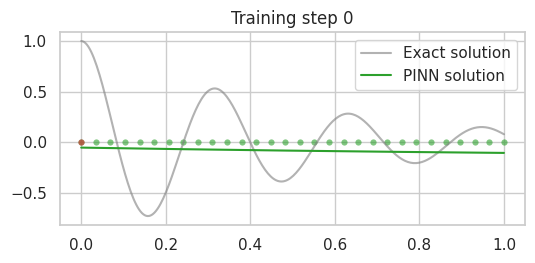

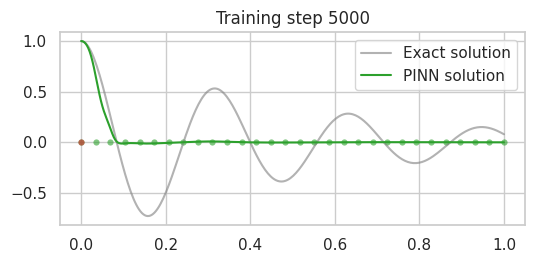

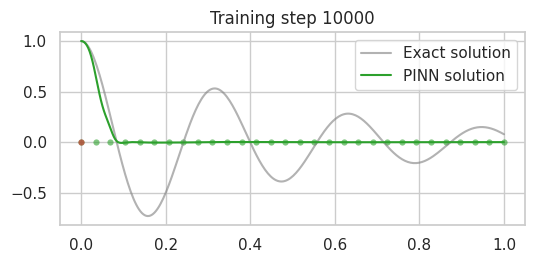

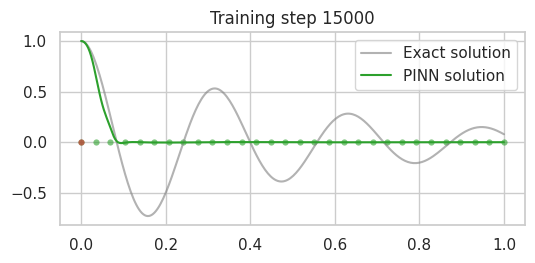

In [61]:
for i in range(15001):
    optim.zero_grad() # reseteamos el gradiente

    # Calculamos la perdida de la condicion de borde
    u = pinn(t_boundary)
    loss1 = (torch.squeeze(u) - 1)**2
    dudt = torch.autograd.grad(u, t_boundary, torch.ones_like(u), create_graph=True)[0] # calculamos la derivada
    loss2 = (torch.squeeze(dudt) - 0)**2

    # Calculamos la perdida de la ecuacion diferencial
    u = pinn(t_physics)
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0] # calculamos la derivada
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0] # calculamos la segunda derivada
    loss3 = torch.mean((d2udt2 + mu*dudt + k*u)**2)

    # Calculamos la perdida total (Custom Loss)
    loss = loss1 + lambda1*loss2 + lambda2*loss3

    # Backward Pass
    loss.backward()

    # Actualizamos los pesos
    optim.step()

    # Visualizamos el resultado cada 5000 iteraciones
    if i % 5000 == 0:
        u = pinn(t_test).detach()
        plt.figure(figsize=(6,2.5))
        plt.scatter(t_physics.detach()[:,0],
                    torch.zeros_like(t_physics)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
        plt.scatter(t_boundary.detach()[:,0],
                    torch.zeros_like(t_boundary)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
        plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
        plt.plot(t_test[:,0], u[:,0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()

## entrenar una PINN para invertir los parámetros subyacentes

La segunda tarea consiste en usar una PINN para **Estimar** parámetros.

Específicamente, nuestras entradas y salidas son:

- Entradas: observaciones con ruido del desplazamiento del oscilador
- Salidas: estimar $\mu$, el coeficiente de fricción

#### Enfoque

De manera similar a lo anterior, la PINN se entrena para aproximar directamente la solución a la ecuación diferencial, es decir

$$
u_{\mathrm{PINN}}(t;\theta) \approx u(t)~,
$$

donde $\theta$ son los parámetros libres de la PINN.

La idea clave aquí es también tratar $\mu$ como un **parámetro aprendible** al entrenar la PINN, de modo que simulamos la solución e invertimos para este parámetro.

#### Función de pérdida

La PINN se entrena con una función de pérdida ligeramente diferente:

$$
\mathcal{L}(\theta, \mu)= \frac{1}{N} \sum^{N}_{i} \left( \left[ m\frac{d^2}{dt^2} + \mu \frac{d}{dt} + k \right] u_{\mathrm{PINN}}(t_{i};\theta)  \right)^2 + \frac{\lambda}{M} \sum^{M}_{j} \left( u_{\mathrm{PINN}}(t_{j};\theta) - u_{\mathrm{obs}}(t_{j}) \right)^2
$$

#### Notas

Hay dos términos en la función de pérdida aquí. El primero es la **pérdida física**, formada de la misma manera que arriba, que asegura que la solución aprendida por la PINN es consistente con la física conocida.

El segundo término se llama **pérdida de datos**, y asegura que la solución aprendida por la PINN se ajuste a las observaciones de la solución (potencialmente con ruido) que están disponibles.

Nota, hemos eliminado los términos de pérdida de los bordes, ya que no los conocemos (es decir, solo se nos dan las mediciones observadas del sistema).

En esta configuración, los parámetros $\theta$ y $\mu$ de la PINN se aprenden **conjuntamente** durante la optimización.

Nuevamente, la autodiferenciación es nuestra amiga y nos permitirá definir fácilmente este problema.


### Puntos de Entrenamiento

True value of mu: 4


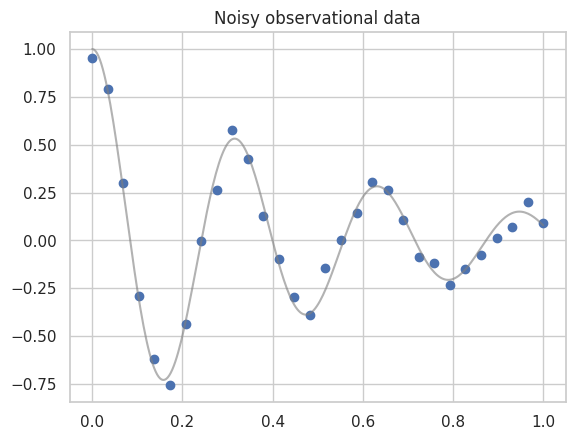

In [62]:
# Creamos data con ruido
d, w0 = 2, 20
print(f"True value of mu: {2*d}")

# Definimos los puntos observacionales para que la red aprenda de los datos
t_obs = torch.linspace(0,1,30).view(-1,1)
u_obs = exact_solution(d, w0, t_obs) + 0.04*torch.randn_like(t_obs)

# definimos los puntos de entrenamiento sobre todo el dominio para la loss de la ecuacion diferencial
t_physics = torch.linspace(0,1,300).view(-1,1).requires_grad_(True)

# parametros del problema
_, k = 2*d, w0**2

plt.figure()
plt.title("Noisy observational data")
plt.scatter(t_obs[:,0], u_obs[:,0])
t_test, u_exact = torch.linspace(0,1,300).view(-1,1), exact_solution(d, w0, t_test)
plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
plt.show()

### Hiperparámetros y Modelo

In [63]:
# Creamos un parametro entrenable para mu
mu = torch.nn.Parameter(torch.zeros(1, requires_grad=True))
mus = []

epochs = 15001
pinn = simple_ffn(N_INPUT=1, N_OUTPUT=1, N_HIDDEN=32, N_LAYERS=3)
optim = torch.optim.Adam(list(pinn.parameters())+[mu],lr=1e-3)
lambda1 = 1e4

### Entrenamiento

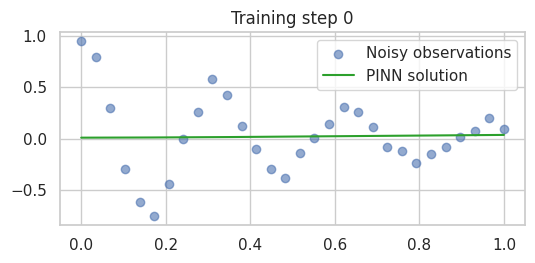

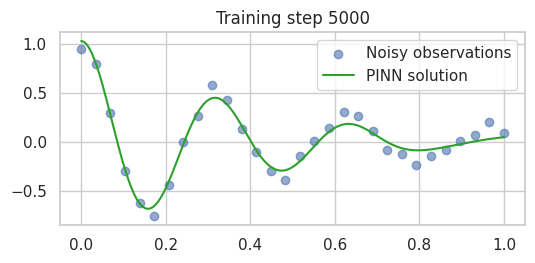

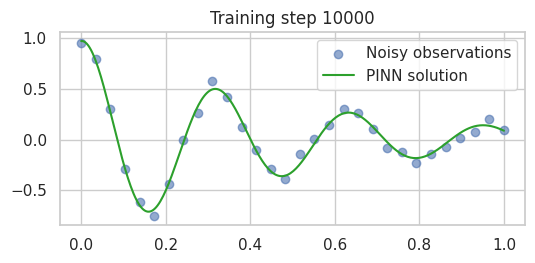

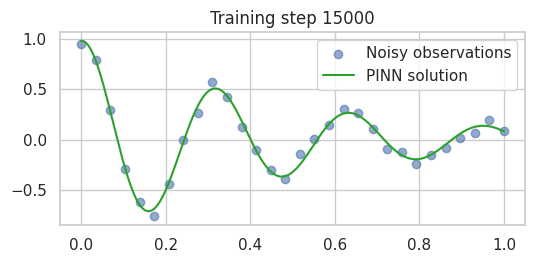

In [64]:
for i in range(epochs):
    # reseteamos el gradiente
    optim.zero_grad()

    # Calculamos la perdida de la ecuacion diferencial
    u = pinn(t_physics)
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]
    loss1 = torch.mean((d2udt2 + mu*dudt + k*u)**2)

    # Calculamos la perdida en funcion de los datos
    u = pinn(t_obs)
    loss2 = torch.mean((u - u_obs)**2)

    # Calculamos la perdida total (Custom Loss)
    loss = loss1 + lambda1*loss2

    # Backward Pass
    loss.backward()

    # Actualizamos los pesos
    optim.step()

    # guardamos el valor de mu
    mus.append(mu.item())

    # Visualizamos el resultado cada 5000 iteraciones
    if i % 5000 == 0:
        u = pinn(t_test).detach()
        plt.figure(figsize=(6,2.5))
        plt.scatter(t_obs[:,0], u_obs[:,0], label="Noisy observations", alpha=0.6)
        plt.plot(t_test[:,0], u[:,0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()

### Estimacion de $\mu$

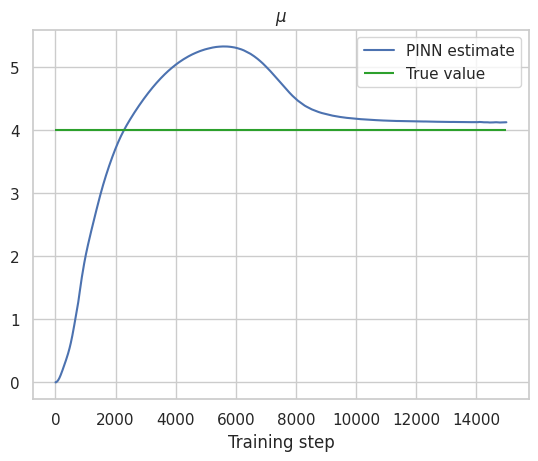

In [65]:
plt.figure()
plt.title("$\mu$")
plt.plot(mus, label="PINN estimate")
plt.hlines(2*d, 0, len(mus), label="True value", color="tab:green")
plt.legend()
plt.xlabel("Training step")
plt.show()

## cómo escala la PINN a oscilaciones de mayor frecuencia



La tarea final es investigar cómo escala la PINN a oscilaciones de mayor frecuencia y qué se puede hacer para mejorar su convergencia.

Específicamente, volvemos a simular la solución al oscilador armónico e incrementamos su frecuencia, $\omega_0$.


la PINN lucha para converger, incluso si el número de puntos de entrenamiento físico aumenta.

Este es un problema más difícil para la PINN de resolver, en parte debido al **sesgo espectral** de las redes neuronales, así como al hecho de que se requieren más puntos de entrenamiento.

#### Enfoque: formulación alternativa "ansatz"

Para acelerar la convergencia, una forma es **asumir algo** sobre la solución.

Por ejemplo, supongamos que sabemos por nuestra intuición física que la solución es de hecho sinusoidal.

Entonces, en lugar de tener la PINN aproximando directamente la solución a la ecuación diferencial, es decir

$$
u_{\mathrm{PINN}}(t;\theta) \approx u(t)~,
$$

En su lugar, usamos la PINN como parte de un ansatz matemático de la solución, es decir

$$
\hat u(t; \theta, \alpha, \beta) = u_{\mathrm{PINN}}(t;\theta)  \sin (\alpha t + \beta) \approx u(t)~,
$$

donde $\alpha, \beta$ se tratan como parámetros adicionales aprendibles.

Comparando este ansatz con la solución exacta

$$
u(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))
$$

Vemos que ahora la PINN solo necesita aprender la función exponencial, lo cual debería ser un problema mucho más fácil.

¡Una vez más, la autodiferenciación nos permite diferenciar fácilmente a través de este ansatz para entrenar la PINN!


### Puntos de Entrenamiento

In [66]:
# Definimos los parametros A y B para la Ansatz
a = torch.nn.Parameter(70*torch.ones(1, requires_grad=True))
b = torch.nn.Parameter(torch.ones(1, requires_grad=True))

# Definimos los puntos de borde
t_boundary = torch.tensor(0.).view(-1,1).requires_grad_(True)

# Definimos los puntos de entrenamiento sobre todo el dominio para la loss de la ecuacion diferencial
t_physics = torch.linspace(0,1,60).view(-1,1).requires_grad_(True)

# Parametros del problema
d, w0 = 2, 80 # las oscilaciones (w0) aumentaron
mu, k = 2*d, w0**2

# Solucion Exacta para comparar con el resultado de la red neuronal
t_test = torch.linspace(0,1,300).view(-1,1)
u_exact = exact_solution(d, w0, t_test)


### Hiperparámetros y Modelo

In [67]:
pinn = simple_ffn(N_INPUT=1, N_OUTPUT=1, N_HIDDEN=32, N_LAYERS=3)
optim = torch.optim.Adam(list(pinn.parameters())+[a,b],lr=1e-3)
lambda1, lambda2 = 1e-1, 1e-4

### Entrenamiento

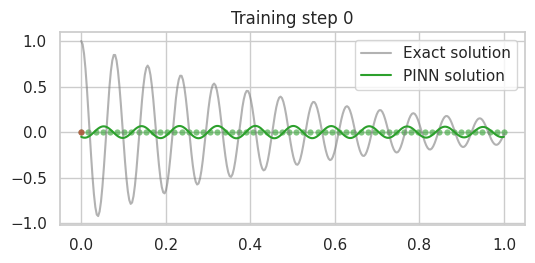

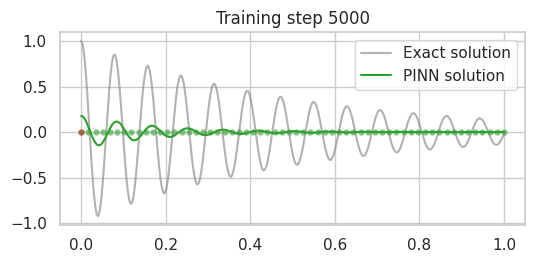

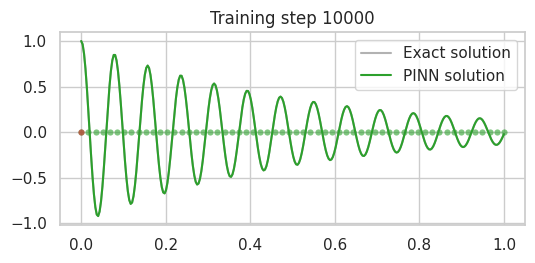

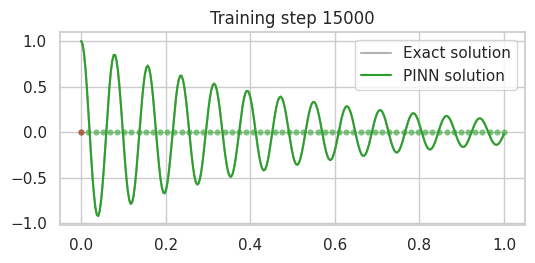

In [68]:
for i in range(15001):
    # reseteamos el gradiente
    optim.zero_grad()

    # Calculamos la perdida de la condicion de borde
    u = pinn(t_boundary)*torch.sin(a*t_boundary+b)
    loss1 = (torch.squeeze(u) - 1)**2
    dudt = torch.autograd.grad(u, t_boundary, torch.ones_like(u), create_graph=True)[0]
    loss2 = (torch.squeeze(dudt) - 0)**2

    # Calculamos la perdida de la ecuacion diferencial
    u = pinn(t_physics)*torch.sin(a*t_physics+b)
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]
    loss3 = torch.mean((d2udt2 + mu*dudt + k*u)**2)

    # Calculamos la perdida total (Custom Loss)
    loss = loss1 + lambda1*loss2 + lambda2*loss3

    # Backward Pass
    loss.backward()

    # Actualizamos los pesos
    optim.step()

    # Visualizamos el resultado cada 5000 iteraciones
    if i % 5000 == 0:
        u = (pinn(t_test)*torch.sin(a*t_test+b)).detach()
        plt.figure(figsize=(6,2.5))
        plt.scatter(t_physics.detach()[:,0],
                    torch.zeros_like(t_physics)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
        plt.scatter(t_boundary.detach()[:,0],
                    torch.zeros_like(t_boundary)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
        plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
        plt.plot(t_test[:,0], u[:,0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()